1. Import Necessary Libraries

In [2]:
! pip install pillow tensorflow keras matplotlib numpy split-folders
import zipfile
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

2. Unzip the dataset

In [5]:
import zipfile
import os

# Path where your uploaded file is stored
zip_path = "archive.zip"

# Folder where you want to extract
extract_path = "raw_data"

# Create folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed! Files are inside:", extract_path)


Extraction completed! Files are inside: raw_data


3. Process & Crop Images

In [6]:
def process_and_crop_images(input_folder, output_folder, target_size=(150, 150)):
    for category in ['NORMAL', 'PNEUMONIA']:
        category_path = os.path.join(input_folder, category)
        save_path = os.path.join(output_folder, category)
        os.makedirs(save_path, exist_ok=True)

        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(category_path, filename)
                    img = Image.open(img_path).convert('RGB')
                    w, h = img.size
                    min_dim = min(w, h)
                    img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                                    (w + min_dim) // 2, (h + min_dim) // 2))
                    img = img.resize(target_size)
                    img.save(os.path.join(save_path, filename))
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

# Set paths
original_data_path = '/content/raw_data'
cropped_data_path = '/content/Processed_Data'

# Run image processing
process_and_crop_images(original_data_path, cropped_data_path)

4. Split folders into train, val, test

In [7]:
splitfolders.ratio(cropped_data_path, output="/content/Final_Data", seed=42, ratio=(.8, .1, .1))

Copying files: 2000 files [00:00, 3833.98 files/s]


In [8]:
import shutil
from google.colab import files

shutil.make_archive('/content/Processed_Data', 'zip', '/content/Processed_Data')

files.download('/content/Processed_Data.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

5. ImageDataGenerators

In [9]:
train_dir = '/content/Final_Data/train'
val_dir = '/content/Final_Data/val'
test_dir = '/content/Final_Data/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False)


Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


6. Define model

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

7. Train model

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_pneumonia_model.h5", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5180 - loss: 0.9047

50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5186 - loss: 0.9016 - val_accuracy: 0.5550 - val_loss: 0.6497
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6616 - loss: 0.5928

50/50 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.6627 - loss: 0.5920 - val_accuracy: 0.7800 - val_loss: 0.4578
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8086 - loss: 0.4474

50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8083 - loss: 0.4477 - val_accuracy: 0.7850 - val_loss: 0.4534
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8015 - loss: 0.4396

50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8015 - loss: 0.4393 - val_accuracy: 0.8200 - val_loss: 0.4270
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8451 - loss: 0.3748 - val_accuracy: 0.7050 - val_loss: 0.5266
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8399 - loss: 0.3817 - val_accuracy: 0.7400 - val_loss: 0.4590
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8442 - loss: 0.3452

50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8444 - loss: 0.3451 - val_accuracy: 0.8850 - val_loss: 0.3024
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8736 - loss: 0.2939

50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8734 - loss: 0.2945 - val_accuracy: 0.9050 - val_loss: 0.2963
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8720 - loss: 0.3225

50/50 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8722 - loss: 0.3221 - val_accuracy: 0.8750 - val_loss: 0.2886
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8803 - loss: 0.3062

50/50 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.8804 - loss: 0.3059 - val_accuracy: 0.9500 - val_loss: 0.2036
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8918 - loss: 0.2854 - val_accuracy: 0.9350 - val_loss: 0.2122
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8951 - loss: 0.2679

50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8952 - loss: 0.2679 - val_accuracy: 0.9400 - val_loss: 0.1966
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9095 - loss: 0.2453

50/50 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9095 - loss: 0.2454 - val_accuracy: 0.9350 - val_loss: 0.1949
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9135 - loss: 0.2547 - val_accuracy: 0.9350 - val_loss: 0.1982
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8958 - loss: 0.2628

50/50 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8959 - loss: 0.2625 - val_accuracy: 0.9450 - val_loss: 0.1571
Epoch 16/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9049 - loss: 0.2411 - val_accuracy: 0.9500 - val_loss: 0.1702
Epoch 17/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9176 - loss: 0.2265 - val_accuracy: 0.9500 - val_loss: 0.1663
Epoch 18/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9227 - loss: 0.2138 - val_accuracy: 0.8800 - val_loss: 0.2891
Epoch 19/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9030 - loss: 0.2466 - val_accuracy: 0.9400 - val_loss: 0.1733
Epoch 20/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9099 - loss: 0.2311 - val_accuracy: 0.9400 - val_loss: 0.1795


8. Evaluate on test set

In [12]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 546ms/step - accuracy: 0.9613 - loss: 0.1260
Test Accuracy: 95.00%


9. Accuracy & Loss Charts


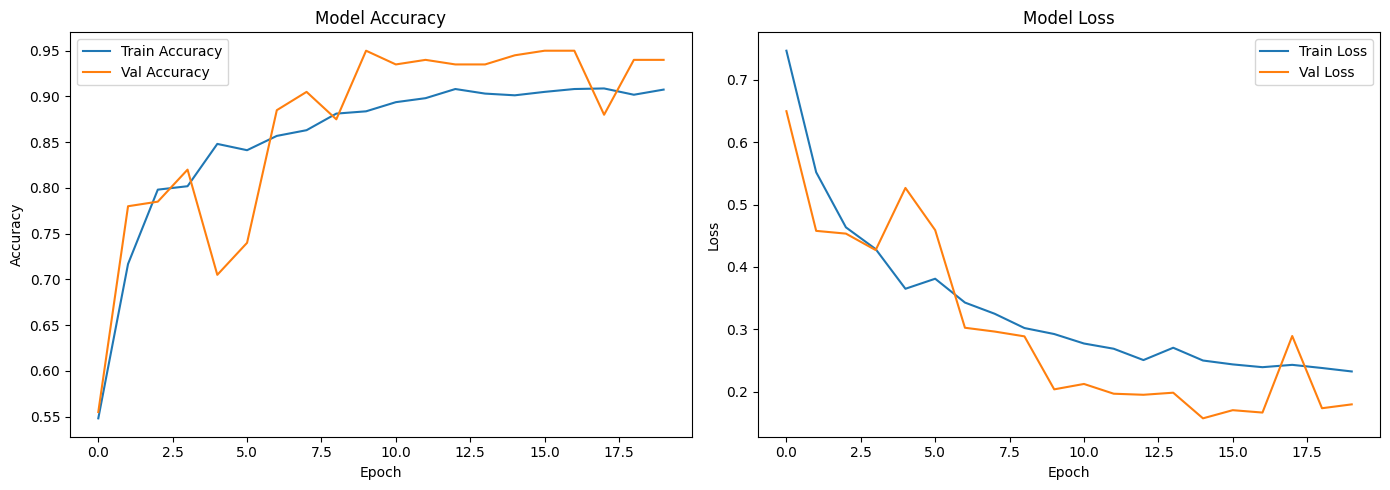

In [13]:
# Plot Accuracy and Loss
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

10. Classify Image (Normal or Pneumonia)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


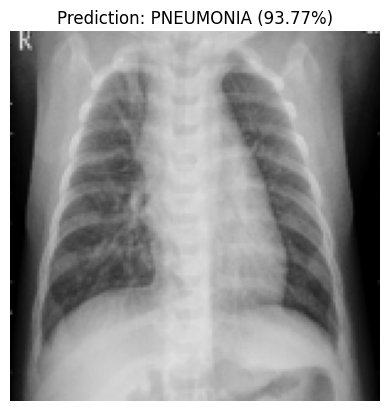

In [17]:
def classify_local_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')

        # Preprocess
        w, h = img.size
        min_dim = min(w, h)
        img = img.crop(((w - min_dim) // 2, (h - min_dim) // 2,
                        (w + min_dim) // 2, (h + min_dim) // 2))
        img = img.resize((150, 150))
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

        prediction = model.predict(img_array)[0][0]
        label = 'PNEUMONIA' if prediction > 0.5 else 'NORMAL'
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Prediction: {label} ({confidence*100:.2f}%)')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

classify_local_image('/content/Processed_Data/PNEUMONIA/PNEUMONIA_1412.png')